In [1]:
import os
os.chdir('/Users/emilycanavan/Desktop/symposium')

In [2]:
import pandas as pd

In [3]:
data = pd.read_excel('pandas_simple.xlsx')

In [4]:
del data['county_code'] #not neccessary

In [5]:
data = data.drop(data[data['denial_reason_1'] == 1111].index)
data = data.drop(data[data['denial_reason_1'] == 7].index)
data = data.drop(data[data['interest_rate'] == 'Exempt'].index)
data = data.drop(data[data['debt_to_income_ratio'] == 'Exempt'].index)
data = data.drop(data[data['combined_loan_to_value_ratio'] == 'Exempt'].index)
data = data.drop(data[data['applicant_age'] == '8888'].index)
#exclude exempt entries, denial reason 7 for incomplete app, and reason codes 1111 & 8888 (which mean NA)

In [6]:
data = data.drop(data[data['action_taken'] == 2].index)
data = data.drop(data[data['action_taken'] == 4].index)
data = data.drop(data[data['action_taken'] == 5].index)
data = data.drop(data[data['action_taken'] == 8].index)
data = data.drop(data[data['action_taken'] == 6].index)
#only including loan originated (1) and application denied (3) entries

In [7]:
data = data[data['state_code'].notna()]
data = data[data['income'].notna()] #delete nulls

In [8]:
data = data[data['applicant_ethnicity_1'].notna()]
data = data[data['debt_to_income_ratio'].notna()]
data = data[data['combined_loan_to_value_ratio'].notna()]
data = data[data['property_value'].notna()] #delete nulls

In [9]:
q_low = data['income'].quantile(0.01)
q_hi  = data['income'].quantile(0.99)
data = data[(data['income'] < q_hi) & (data['income'] > q_low)] 
#exclude outliers in new dataset

In [10]:
#creating categorical columns for demographic data
e_dict = {1:'Hispanic or Latino',2:'Not Hispanic or Latino',
                       3:'Not Provided',4:'Not Provided'} 
data['ethnicity_categorical'] = data['applicant_ethnicity_1'].map(e_dict)
s_dict = {1:'Male',2:'Female',3:'Not Provided',4:'Not Applicable',6:'Both Selections Made'}
data['sex_categorical'] = data['applicant_sex'].map(s_dict)
r_dict = {1:'Native American or Alaska Native',2:'Asian',3:'Asian Indian',
                   22:'Chinese',23:'Filipino',24:'Japanese',25:'Korean',
                  26:'Vietnamese',27:'Other Asian',3:'Black or African American',
                  4:'Native Hawaiian or Other Pacific Islander',41:'Native Hawaiian',
                  42:'Guamanian or Chamorro',43:'Samoan',44:'Other Pacific Islander',
                  5:'White',6:'Not Provided'}
data['race_categorical'] = data['applicant_race_1'].map(r_dict)

In [15]:
#creating categorical columns for other variables
action_dictionary = {1:'Approved',3:'Denied'}
data['action_categorical'] = data['action_taken'].map(action_dictionary)
purpose_dictionary = {1:'Home Purchase',2:'Home Improvement',31:'Refinancing',
                      32:'Cash-Out Refinancing',4:'Other',5:'Not Applicable'}
data['purpose_categorical'] = data['loan_purpose'].map(purpose_dictionary)
type_dictionary = {1:'Conventional',2:'FHA Insured',3:'VA Guaranteed',
                   4:'USDA RHA or FSA Guaranteed'}
data['type_categorical'] = data['loan_type'].map(type_dictionary)
occupancy_dictionary = {1:'Principal Residence',2:'Second Residence',3:'Investment Property'}
data['occupancy_categorical'] = data['occupancy_type'].map(occupancy_dictionary)
denial_dictionary = {1:'Debt to Income Ratio',2:'Employment History',
                     3:'Credit History',4:'Collateral',5:'Insufficent Cash',
                    6:'Unverifiable Information',
                    8:'Mortgage Insurance Denied',9:'Other',10:'Not Applicable'}
data['denial_categorical'] = data['denial_reason_1'].map(denial_dictionary)

In [21]:
#rounding LtoV ratio numbers, then changing them to integers 
data['combined_loan_to_value_ratio'] = data['combined_loan_to_value_ratio'].astype('float64')
import numpy as np
data['combined_loan_to_value_ratio'] = np.ceil(data['combined_loan_to_value_ratio']).astype(int)

In [22]:
#change to integers
data['income'] = data['income'].astype(int) 
data['property_value'] = data['property_value'].astype(int)

In [23]:
#new column where 1 = favorable DtoI ratio and 0 = unfavorable DtoI ratio on the basis of favorable = <=43%
def map_debt_to_income(value):
    if value in ['30%-<36%', '40', '37', '20%-<30%', '36', '38', '39', '<20%', '42', '41', '43']:
        return 1
    elif value in ['>60%', '45', '48', '44', '47', '50%-60%', '49', '46']:
        return 0
    else:
        return None 
data['DI_indicator'] = data['debt_to_income_ratio'].apply(map_debt_to_income)

In [26]:
#deleting columns where dictionaries were mapped to create categorical, or aren't pertient to analysis
del(data['loan_purpose'],data['occupancy_type'],data['loan_type'])
del(data['state_code'],data['applicant_ethnicity_1'],data['applicant_ethnicity_observed'])
del(data['applicant_race_1'],data['applicant_race_observed'],data['interest_rate'])
del(data['applicant_sex'],data['applicant_sex_observed'],data['denial_reason_1'])

In [27]:
#creating a list of categorical columns 
cat_cols = ['ethnicity_categorical','sex_categorical','race_categorical','action_categorical','purpose_categorical',
           'type_categorical','occupancy_categorical','denial_categorical','applicant_age','debt_to_income_ratio']

In [28]:
#remapping action taken where 1=loan originated 0=denied application
data['action_taken'].unique()
def map_action_binary(value):
    if value in [1]:
        return 1
    else:
        return 0
data['action_taken'] = data['action_taken'].apply(map_action_binary)

In [29]:
#creating dummy variables for each category
df = pd.get_dummies(data,columns=cat_cols,drop_first=True)

In [37]:
df_subset = df[0:35000] #subsetting the data due to the size being too large to visualize using SHAP

In [39]:
from sklearn.model_selection import train_test_split #training and testing the model

In [40]:
#here, we omit the demographic data from the analysis to focus on key ratios in credit underwriting.
#our preprocessing makes the inclusion of demographics possible, but for the sake of our analysis, we will omit it.
feature_cols = ['income', 'combined_loan_to_value_ratio', 'DI_indicator','loan_amount','property_value',
               'debt_to_income_ratio_30%-<36%',
 'debt_to_income_ratio_36',
 'debt_to_income_ratio_37',
 'debt_to_income_ratio_38',
 'debt_to_income_ratio_39',
 'debt_to_income_ratio_40',
 'debt_to_income_ratio_41',
 'debt_to_income_ratio_42',
 'debt_to_income_ratio_43',
 'debt_to_income_ratio_44',
 'debt_to_income_ratio_45',
 'debt_to_income_ratio_46',
 'debt_to_income_ratio_47',
 'debt_to_income_ratio_48',
 'debt_to_income_ratio_49',
 'debt_to_income_ratio_50%-60%',
 'debt_to_income_ratio_<20%',
 'debt_to_income_ratio_>60%']
X = df_subset[feature_cols]
y = df_subset.action_taken

In [41]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.45,random_state=42)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [43]:
#we place double weight on denials in our algorithm as they only make up 13% of our dataset
dict_weights = {1:1, 0:2}
rfc = RandomForestClassifier(n_estimators=300,class_weight=dict_weights,max_depth=9,random_state=42,n_jobs=-1)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print("Accuracy: ", accuracy_score(y_test,y_pred))
print('\n')
print("Confusion Matrix")
print('\n')
print(confusion_matrix(y_test,y_pred))
#we see from this output that our model is 91.2% accurate with 1377 false values

Accuracy:  0.9125714285714286


Confusion Matrix


[[  651  1050]
 [  327 13722]]


In [44]:
import eli5

In [45]:
eli5.show_weights(rfc, feature_names = feature_cols)
#shows the model is largely predicting on DtoI ratio 

Weight,Feature
0.3241 ± 0.2891,debt_to_income_ratio_>60%
0.1904 ± 0.0914,combined_loan_to_value_ratio
0.1119 ± 0.1341,debt_to_income_ratio_50%-60%
0.0950 ± 0.1630,DI_indicator
0.0748 ± 0.0650,income
0.0730 ± 0.0447,loan_amount
0.0669 ± 0.0379,property_value
0.0107 ± 0.0331,debt_to_income_ratio_44
0.0090 ± 0.0329,debt_to_income_ratio_49
0.0077 ± 0.0275,debt_to_income_ratio_48


In [46]:
import warnings
warnings.filterwarnings('ignore')

In [47]:
eli5.show_prediction(rfc,X_train.iloc[1],
feature_names=feature_cols, top=20, show_feature_values=True)
#predicted true positive features: DI is favorable, DI ratio less than 60, etc.

In [48]:
import shap

In [50]:
explainer = shap.Explainer(rfc, X_train)

In [51]:
shap_values = explainer.shap_values(X_test)

100%|===================| 31497/31500 [12:23<00:00]        

In [55]:
type(shap_values)

list

In [54]:
shap_obj=explainer(X)

100%|===================| 69961/70000 [26:34<00:00]        

In [56]:
type(shap_obj)

shap._explanation.Explanation

In [58]:
from shap.plots import beeswarm

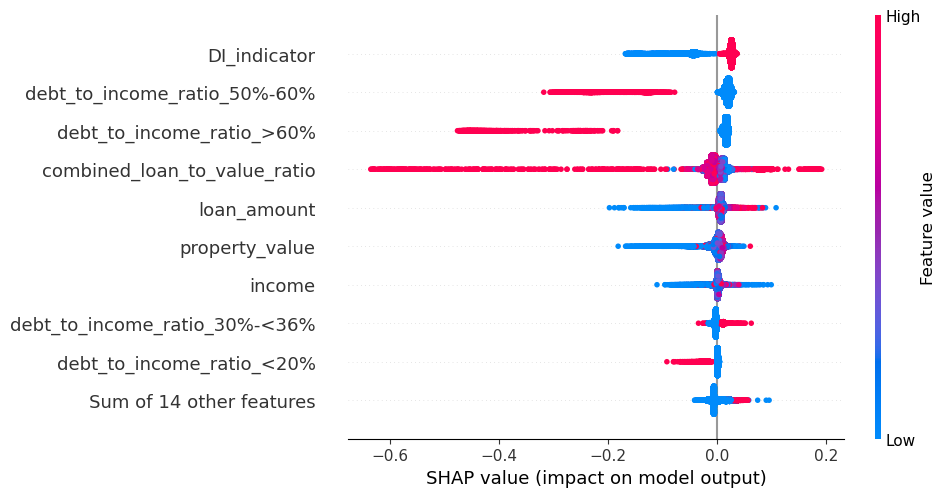

In [67]:
beeswarm(shap_obj[:,:,1])

In [70]:
from shap.plots import violin

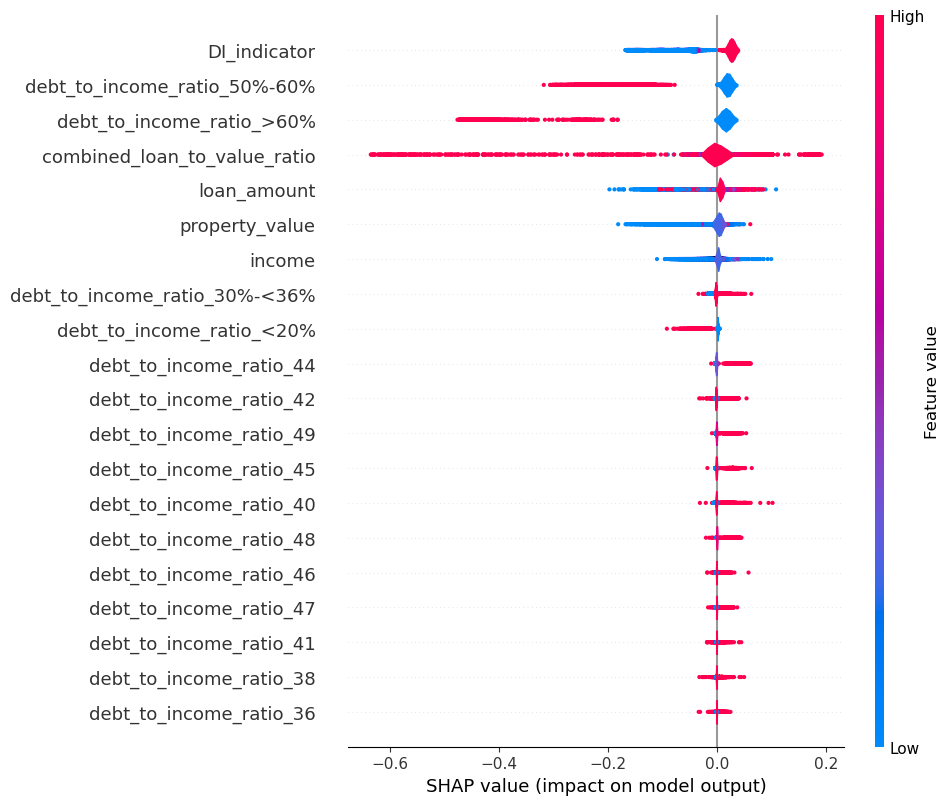

In [77]:
shap.plots.violin(shap_obj[:,:,1])

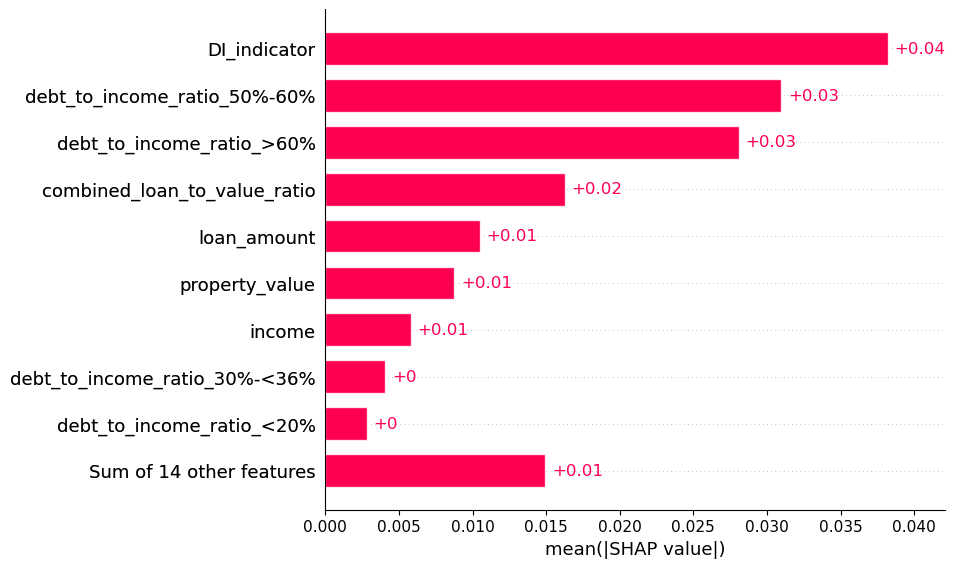

In [84]:
shap.plots.bar(shap_obj[:,:,0])